In [1]:
import torch # import torch modules
import torch.nn as nn

In [2]:
class ResSE_Block(nn.Module): # resSE block as the foundation of encoder and decoder blocks
  def __init__(self, input_channels, size):
    super().__init__()
    self.conv = nn.Conv3d(in_channels=input_channels, out_channels=input_channels, kernel_size=3, stride=1, padding=1)
    self.instnorm = nn.InstanceNorm3d(num_features=4) #n features = channels
    self.relu = nn.ReLU()
    # add variables for SE
    self.globalpooling = torch.nn.AvgPool3d(kernel_size=size)
    self.input_channels = input_channels
    self.fclayer1 = nn.Linear(in_features=input_channels, out_features=input_channels//4, bias=True) # reduces channels by reduction ratio
    self.fclayer2 = nn.Linear(in_features=input_channels//4, out_features=input_channels, bias=True) # expands channels back
    self.sigmoid = nn.Sigmoid()
    
  def forward(self, x):
    # print(x.shape)
    # print("\nGoing to ResSE")

    # residual block
    x1 = self.conv(x)
    x2 = self.instnorm(x1)
    x3 = self.relu(x1)
    x4 = self.conv(x3)
    x5 = self.instnorm(x4)
    # print("x5")
    print(x5.shape)

    # the SE module
    x6 = self.globalpooling(x5) # global pooling layer to decrease spatial dimensions
    # print(x6.shape)

    x7 = x6.view(1, -1) # you need to view it in [1, x] format so it can go through an fc layer in pytorch (https://stackoverflow.com/questions/65945996/1d-cnn-on-pytorch-mat1-and-mat2-shapes-cannot-be-multiplied-10x3-and-10x2)
    # print(x7.shape)

    x7 = self.fclayer1(x7) # reduce channel
    # print(x7.shape)
    x8 = self.relu(x7)
    # print(x8.shape)
    x9 = self.fclayer2(x8) # increase channel
    # print(x9.shape)
    x10 = self.sigmoid(x9)
    # print(x10.shape)

    # scale - basically you go through the layers with [1, x] because it needs that format
    # but then for scaling, you first need to add two extra dimensions in end (so it's same size/has the same number of dimensions as the input for SE module)
    x11 = x10.view(1, self.input_channels, 1, 1, 1) # basically the size you want it to be - channels stays the same
    # print(x11.shape)

    # multiply the weights by the channels
    x12 = torch.multiply(x5, x11) # e.x. [1, 24, 1, 1, 1] and [1, 24, 128, 128, 128]
    # (number of batches and channels for which you need to multiply each weight to the channel, so should be same #)
    # print(x12.shape)

    # summation and then ReLU
    x13 = torch.add(x12, x)
    # print(x13.shape)
    x14 = self.relu(x13)
    print(x14.shape)
    # print("Done ResSE\n")
    
    return x14 # returns output

In [3]:
# test ResSE_Block class with first block

input = torch.randn((1, 24,128,128,128), dtype=torch.float)

trial = ResSE_Block(input_channels=24, size=128)

print(trial)
print()

out = trial(input)
print(out.shape)

ResSE_Block(
  (conv): Conv3d(24, 24, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (instnorm): InstanceNorm3d(4, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (relu): ReLU()
  (globalpooling): AvgPool3d(kernel_size=128, stride=128, padding=0)
  (fclayer1): Linear(in_features=24, out_features=6, bias=True)
  (fclayer2): Linear(in_features=6, out_features=24, bias=True)
  (sigmoid): Sigmoid()
)

torch.Size([1, 24, 128, 128, 128])
torch.Size([1, 24, 128, 128, 128])
torch.Size([1, 24, 128, 128, 128])


In [4]:
# test ResSE_Block class

input = torch.randn((1, 48, 96, 96, 96), dtype=torch.float)
trial = ResSE_Block(input_channels=48, size=96)

print(trial)
print()

out = trial(input)
print(out.shape)

ResSE_Block(
  (conv): Conv3d(48, 48, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (instnorm): InstanceNorm3d(4, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (relu): ReLU()
  (globalpooling): AvgPool3d(kernel_size=96, stride=96, padding=0)
  (fclayer1): Linear(in_features=48, out_features=12, bias=True)
  (fclayer2): Linear(in_features=12, out_features=48, bias=True)
  (sigmoid): Sigmoid()
)

torch.Size([1, 48, 96, 96, 96])
torch.Size([1, 48, 96, 96, 96])
torch.Size([1, 48, 96, 96, 96])


In [5]:
class EncoderBlock(nn.Module): # if input is x, y, y, y --> output should be x*2, y/2, y/2, y/2 (except first and last block)
  def __init__(self, n_blocks, input_channels, output_channels, size):
    super().__init__()
    self.resSEblock = ResSE_Block(input_channels, size)
    self.downsample = nn.Conv3d(in_channels=input_channels, out_channels=output_channels, kernel_size=3, stride=2, padding=1)
    self.n_blocks = n_blocks
  def forward(self, x, downsample_bool):
    # print(x.shape)
    # print(x1.shape)
    if self.n_blocks==1:
      x1 = self.resSEblock(x)
      # print(" 1 downsample ")
      # print("\noutput of encoder block")
      if (downsample_bool==True):
        x2 = self.downsample(x1)
        return x1, x2
        # print(x2.shape)
        # print()
      return x1, x1
    else:
      # print("side case x shape")
      # print(x.shape)
      x1 = self.resSEblock(x)
      # print("after first res")
      x2 = self.resSEblock(x1)
      # print("\noutput of encoder block")
      x3 = self.downsample(x2)
      # print(x3.shape)
      print()
      return x2, x3

In [6]:
# test encoder block with first block
input = torch.randn((1, 24,128,128,128), dtype=torch.float)

trial = EncoderBlock(n_blocks=1, input_channels=24, output_channels=48, size=128) # 1st encoder block

print(trial)
print()

out = trial(input, True)

EncoderBlock(
  (resSEblock): ResSE_Block(
    (conv): Conv3d(24, 24, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (instnorm): InstanceNorm3d(4, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): ReLU()
    (globalpooling): AvgPool3d(kernel_size=128, stride=128, padding=0)
    (fclayer1): Linear(in_features=24, out_features=6, bias=True)
    (fclayer2): Linear(in_features=6, out_features=24, bias=True)
    (sigmoid): Sigmoid()
  )
  (downsample): Conv3d(24, 48, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
)

torch.Size([1, 24, 128, 128, 128])
torch.Size([1, 24, 128, 128, 128])


In [7]:
# last block
input = torch.randn((1, 384,8,8,8), dtype=torch.float)

trial = EncoderBlock(n_blocks=1, input_channels=384, output_channels=384, size=8)

print(trial)
print()

out = trial(input, False)
# print(out.shape)

EncoderBlock(
  (resSEblock): ResSE_Block(
    (conv): Conv3d(384, 384, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (instnorm): InstanceNorm3d(4, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): ReLU()
    (globalpooling): AvgPool3d(kernel_size=8, stride=8, padding=0)
    (fclayer1): Linear(in_features=384, out_features=96, bias=True)
    (fclayer2): Linear(in_features=96, out_features=384, bias=True)
    (sigmoid): Sigmoid()
  )
  (downsample): Conv3d(384, 384, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
)

torch.Size([1, 384, 8, 8, 8])
torch.Size([1, 384, 8, 8, 8])


In [8]:
class SA_Block1(nn.Module): # first scale attention block for the last decoding block
  def __init__(self):
    super().__init__()
    # target is 24x128x128x128
    self.conv_initial1 = nn.Conv3d(in_channels=48, out_channels=24, kernel_size=1, stride=1) # conv for decreasing s2 channels
    self.conv_initial2 = nn.Conv3d(in_channels=96, out_channels=24, kernel_size=1, stride=1) # conv for decreasing s3 channels
    self.conv_initial3 = nn.Conv3d(in_channels=192, out_channels=24, kernel_size=1, stride=1) # conv for decreasing s4 channels

    self.instancenorm = nn.InstanceNorm3d(24)
    self.relu = nn.ReLU()

    self.global_avg_pooling = nn.AdaptiveAvgPool3d(1) # global pooling to make each channel one value
    self.fcn1 = nn.Linear(in_features=24, out_features=6) # first linear layer to reduce channel size by ratio

    self.fcn2 = nn.Linear(in_features=6, out_features=24) # second linear layer to increase channel size by ratio
    self.sigmoid = nn.Sigmoid()

    self.softmax = nn.Softmax(dim=1) # softmax for channels
    
  def forward(self, s1, s2, s3, s4):
    channels = s1.shape[1] # number of channels we're working with 
    print("channels: " + str(channels) + "\n")

    # decreasing channels using Conv3D
    s2 = self.conv_initial1(s2) 
    s3 = self.conv_initial2(s3)
    s4 = self.conv_initial3(s4)

    print(s1.shape)
    print(s2.shape)
    print(s3.shape)
    print(s4.shape)
    print()

    # instance normalization 
    s2 = self.instancenorm(s2)
    s3 = self.instancenorm(s3)
    s4 = self.instancenorm(s4)

    print(s1.shape)
    print(s2.shape)
    print(s3.shape)
    print(s4.shape)
    print()

    # relu
    s2 = self.relu(s2)
    s3 = self.relu(s3)
    s4 = self.relu(s4)

    print(s1.shape)
    print(s2.shape)
    print(s3.shape)
    print(s4.shape)
    print()

    # trilinear upsampling for scales 2, 3, 4 (their spatial sizes - w, h, l)
    s2 = torch.nn.functional.interpolate(s2, size=(128,128,128), mode='trilinear')
    s3 = torch.nn.functional.interpolate(s3, size=(128,128,128), mode='trilinear')
    s4 = torch.nn.functional.interpolate(s4, size=(128,128,128), mode='trilinear')

    print(s1.shape)
    print(s2.shape)
    print(s3.shape)
    print(s4.shape)
    print()

    # summation of all scales 
    p1 = s1 + s2 + s3 +s4
    print(p1.shape)

    # global pooling layer
    G1 = self.global_avg_pooling(p1)
    print(G1.shape)
    print()

    # take out the last two dimensions of [1, x, 1, 1]
    G1 = G1.view(1, -1) # -1 means it adjusts itself
    print(G1.shape)
    print()

    # first fully connected layer
    g1 = self.fcn1(G1)
    print(g1.shape)
    print()

    # second fully connected layer + sigmoid
    E1 = self.fcn2(g1)
    E1 = self.sigmoid(E1)
    # softmax
    E1 = self.softmax(E1)
    print(E1.shape)

    # second fully connected layer + sigmoid
    E2 = self.fcn2(g1)
    E2 = self.sigmoid(E2)
    # softmax
    E2 = self.softmax(E2)
    print(E2.shape)

    # second fully connected layer + sigmoid
    E3 = self.fcn2(g1)
    E3 = self.sigmoid(E3)
    # softmax
    E3 = self.softmax(E3)
    print(E3.shape)

    # second fully connected layer + sigmoid
    E4 = self.fcn2(g1)
    E4 = self.sigmoid(E4)
    # softmax
    E4 = self.softmax(E4)
    print(E4.shape)
    print()

    # add the last 2 dimensions so there's the same amount of dimensions in the E and the beginning scale (for multiplication later)
    E1 = E1.view(1, channels, 1, 1, 1)
    E2 = E2.view(1, channels, 1, 1, 1)
    E3 = E3.view(1, channels, 1, 1, 1)
    E4 = E4.view(1, channels, 1, 1, 1)
    print(E1.shape)
    print(E2.shape)
    print(E3.shape)
    print(E4.shape)
    print()

    # multiply the weights for the channels with the channels in all the scales
    w1_S11 = torch.multiply(E1, s1)
    w2_S12 = torch.multiply(E2, s2)
    w3_S13 = torch.multiply(E3, s3)
    w4_S14 = torch.multiply(E4, s4)
    print(w1_S11.shape)
    print(w2_S12.shape)
    print(w3_S13.shape)
    print(w4_S14.shape)
    print()

    # adding all the scales with weighted channels
    output = w1_S11 + w2_S12 + w3_S13 + w4_S14
    print(output.shape)
    return output

In [9]:
# test SA_Block1
s1 = torch.randn((1,24,128,128,128), dtype=torch.float)
s2 = torch.randn((1,48,64,64,64), dtype=torch.float)
s3 = torch.randn((1,96,32,32,32), dtype=torch.float)
s4 = torch.randn((1,192,16,16,16), dtype=torch.float)

model = SA_Block1()

print(model)
print()

out = model(s1, s2, s3, s4)

SA_Block1(
  (conv_initial1): Conv3d(48, 24, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (conv_initial2): Conv3d(96, 24, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (conv_initial3): Conv3d(192, 24, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (instancenorm): InstanceNorm3d(24, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (relu): ReLU()
  (global_avg_pooling): AdaptiveAvgPool3d(output_size=1)
  (fcn1): Linear(in_features=24, out_features=6, bias=True)
  (fcn2): Linear(in_features=6, out_features=24, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=1)
)

channels: 24

torch.Size([1, 24, 128, 128, 128])
torch.Size([1, 24, 64, 64, 64])
torch.Size([1, 24, 32, 32, 32])
torch.Size([1, 24, 16, 16, 16])

torch.Size([1, 24, 128, 128, 128])
torch.Size([1, 24, 64, 64, 64])
torch.Size([1, 24, 32, 32, 32])
torch.Size([1, 24, 16, 16, 16])

torch.Size([1, 24, 128, 128, 128])
torch.Size([1, 24, 64, 64, 64])
torch.Size([1, 24, 32, 32, 32])
torch.Size([1, 24, 16, 16, 16])

to

In [10]:
class SA_Block2(nn.Module):
  def __init__(self):
    super().__init__()
    # target is 48x64x64x64
    self.maxpool_initial1 = nn.MaxPool3d(kernel_size=2, stride=2) # maxpooling for first scale (reduce spatial size)
    self.conv1 = nn.Conv3d(in_channels=24, out_channels=48, kernel_size=1, stride=1) # conv for increasing s1 channels
    self.conv_initial3 = nn.Conv3d(in_channels=96, out_channels=48, kernel_size=1, stride=1) # conv for decreasing s3 channels
    self.conv_initial4 = nn.Conv3d(in_channels=192, out_channels=48, kernel_size=1, stride=1) # conv for decreasing s4 channels

    self.instancenorm = nn.InstanceNorm3d(24)
    self.relu = nn.ReLU()

    self.global_avg_pooling = nn.AdaptiveAvgPool3d(1) # global pooling to make each channel one value
    self.fcn1 = nn.Linear(in_features=48, out_features=12) # first linear layer to reduce channel size by ratio

    self.fcn2 = nn.Linear(in_features=12, out_features=48) # second linear layer to increase channel size by ratio
    self.sigmoid = nn.Sigmoid()

    self.softmax = nn.Softmax(dim=1) # softmax for channels
    
  def forward(self, s1, s2, s3, s4):
    channels = s2.shape[1]
    print("channels: " + str(channels) + "\n")

    # increasing spatial sizes of scale 1
    s1 = self.maxpool_initial1(s1)
    # increasing spatial sizes of scale 1 (2 times)
    s1 = self.conv1(s1) # increasing channels for scale 1
    s3 = self.conv_initial3(s3) # decreasing channels for scale 3
    s4 = self.conv_initial4(s4) # decreasing channels for scale 4

    print(s1.shape)
    print(s2.shape)
    print(s3.shape)
    print(s4.shape)
    print()

    # instance normalization 
    s1 = self.instancenorm(s1)
    s3 = self.instancenorm(s3)
    s4 = self.instancenorm(s4)

    print(s1.shape)
    print(s3.shape)
    print(s4.shape)
    print()

    # relu
    s1 = self.relu(s1)
    s3 = self.relu(s3)
    s4 = self.relu(s4)

    print(s1.shape)
    print(s3.shape)
    print(s4.shape)
    print()

    # trilinear upsampling for scales 3 and 4 (their spatial sizes - w, h, l)
    s3 = torch.nn.functional.interpolate(s3, size=(64,64,64), mode='trilinear')
    s4 = torch.nn.functional.interpolate(s4, size=(64,64,64), mode='trilinear')

    print(s1.shape)
    print(s2.shape)
    print(s3.shape)
    print(s4.shape)
    print()

    # summation of all scales
    p2 = s1 + s2 + s3 +s4
    print(p2.shape)

    # global pooling layer
    G2 = self.global_avg_pooling(p2)
    print(G2.shape)
    print()

    # take out the last two dimensions of [1, x, 1, 1]
    G2 = G2.view(1, -1) # -1 means it adjusts itself
    print(G2.shape)
    print()

    # first fully connected layer
    g2 = self.fcn1(G2)
    print(g2.shape)
    print()

    # second fully connected layer + sigmoid
    E1 = self.fcn2(g2)
    E1 = self.sigmoid(E1)
    E1 = self.softmax(E1)
    print(E1.shape)

    # second fully connected layer + sigmoid
    E2 = self.fcn2(g2)
    E2 = self.sigmoid(E2)
    # softmax
    E2 = self.softmax(E2)
    print(E2.shape)

    # second fully connected layer + sigmoid
    E3 = self.fcn2(g2)
    E3 = self.sigmoid(E3)
    # softmax
    E3 = self.softmax(E3)
    print(E3.shape)

    # second fully connected layer + sigmoid
    E4 = self.fcn2(g2)
    E4 = self.sigmoid(E4)
    # softmax
    E4 = self.softmax(E4)
    print(E4.shape)
    print()

    # add the last 2 dimensions so there's the same amount of dimensions in the E and the beginning scale (for multiplication later)
    E1 = E1.view(1, channels, 1, 1, 1)
    E2 = E2.view(1, channels, 1, 1, 1)
    E3 = E3.view(1, channels, 1, 1, 1)
    E4 = E4.view(1, channels, 1, 1, 1)
    print(E1.shape)
    print(E2.shape)
    print(E3.shape)
    print(E4.shape)
    print()

    # multiply the weights for the channels with the channels in all the scales
    w1_S21 = torch.multiply(E1, s1)
    w2_S22 = torch.multiply(E2, s2)
    w3_S23 = torch.multiply(E3, s3)
    w4_S24 = torch.multiply(E4, s4)
    print(w1_S21.shape)
    print(w2_S22.shape)
    print(w3_S23.shape)
    print(w4_S24.shape)
    print()

    # adding all the scales with weighted channels
    output = w1_S21 + w2_S22 + w3_S23 + w4_S24
    print(output.shape)
    return output

In [11]:
# test SA_Block2
s1 = torch.randn((1,24,128,128,128), dtype=torch.float)
s2 = torch.randn((1,48,64,64,64), dtype=torch.float)
s3 = torch.randn((1,96,32,32,32), dtype=torch.float)
s4 = torch.randn((1,192,16,16,16), dtype=torch.float)

model = SA_Block2()

print(model)
print()

out = model(s1, s2, s3, s4)

SA_Block2(
  (maxpool_initial1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv3d(24, 48, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (conv_initial3): Conv3d(96, 48, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (conv_initial4): Conv3d(192, 48, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (instancenorm): InstanceNorm3d(24, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (relu): ReLU()
  (global_avg_pooling): AdaptiveAvgPool3d(output_size=1)
  (fcn1): Linear(in_features=48, out_features=12, bias=True)
  (fcn2): Linear(in_features=12, out_features=48, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=1)
)

channels: 48

torch.Size([1, 48, 64, 64, 64])
torch.Size([1, 48, 64, 64, 64])
torch.Size([1, 48, 32, 32, 32])
torch.Size([1, 48, 16, 16, 16])

torch.Size([1, 48, 64, 64, 64])
torch.Size([1, 48, 32, 32, 32])
torch.Size([1, 48, 16, 16, 16])

torch.Size([1, 48, 64, 64, 64])
torch.Size([1, 48, 32, 32, 32])
torch.Size([1, 48

In [12]:
class SA_Block3(nn.Module):
  def __init__(self):
    super().__init__()
    # target is 96x32x32x32
    self.maxpool_initial1 = nn.MaxPool3d(kernel_size=2, stride=2) # maxpooling for 1st and 2nd scale (reduce spatial size)
    self.conv1 = nn.Conv3d(in_channels=24, out_channels=96, kernel_size=1, stride=1) # conv for increasing s1 channels
    self.conv2 = nn.Conv3d(in_channels=48, out_channels=96, kernel_size=1, stride=1) # conv for increasing s2 channels
    self.conv_initial4 = nn.Conv3d(in_channels=192, out_channels=96, kernel_size=1, stride=1) # conv for decreasing s4 channels

    self.instancenorm = nn.InstanceNorm3d(24)
    self.relu = nn.ReLU()

    self.global_avg_pooling = nn.AdaptiveAvgPool3d(1) # global pooling to make each channel one value
    self.fcn1 = nn.Linear(in_features=96, out_features=24) # first linear layer to reduce channel size by ratio

    self.fcn2 = nn.Linear(in_features=24, out_features=96)  # second linear layer to increase channel size by ratio
    self.sigmoid = nn.Sigmoid()

    # softmax for channels
    self.softmax = nn.Softmax(dim=1)
    
  def forward(self, s1, s2, s3, s4):
    channels = s3.shape[1]
    print("channels: " + str(channels) + "\n")

    # increasing spatial sizes of scale 1 (2 times)
    s1 = self.maxpool_initial1(s1)
    s1 = self.maxpool_initial1(s1)
    # increasing channels for scale 1
    s1 = self.conv1(s1)
    # increasing spatial sizes of scale 2
    s2 = self.maxpool_initial1(s2)
    # increasing channels for scale 2
    s2 = self.conv2(s2)
    s4 = self.conv_initial4(s4) # decreasing channels for scale 4

    print(s1.shape)
    print(s2.shape)
    print(s3.shape)
    print(s4.shape)
    print()

    # instance normalization 
    s1 = self.instancenorm(s1)
    s2 = self.instancenorm(s2)
    s4 = self.instancenorm(s4)

    print(s1.shape)
    print(s2.shape)
    print(s3.shape)
    print(s4.shape)
    print()

    # relu
    s1 = self.relu(s1)
    s2 = self.relu(s2)
    s4 = self.relu(s4)

    print(s1.shape)
    print(s2.shape)
    print(s3.shape)
    print(s4.shape)
    print()

    # trilinear upsampling for scales 3 and 4 (their spatial sizes - w, h, l)
    s4 = torch.nn.functional.interpolate(s4, size=(32,32,32), mode='trilinear')

    print(s1.shape)
    print(s2.shape)
    print(s3.shape)
    print(s4.shape)
    print()

    # summation of all scales
    p3 = s1 + s2 + s3 +s4
    print(p3.shape)

    # global pooling layer
    G3 = self.global_avg_pooling(p3)
    print(G3.shape)
    print()

    # take out the last two dimensions of [1, x, 1, 1]
    G3 = G3.view(1, -1) # -1 means it adjusts itself
    print(G3.shape)
    print()

    # first fully connected layer
    g3 = self.fcn1(G3)
    print(g3.shape)
    print()

    # second fully connected layer + sigmoid
    E1 = self.fcn2(g3)
    E1 = self.sigmoid(E1)
    # softmax
    E1 = self.softmax(E1)
    print(E1.shape)

    # second fully connected layer + sigmoid
    E2 = self.fcn2(g3)
    E2 = self.sigmoid(E2)
    # softmax
    E2 = self.softmax(E2)
    print(E2.shape)

    # second fully connected layer + sigmoid
    E3 = self.fcn2(g3)
    E3 = self.sigmoid(E3)
    # softmax
    E3 = self.softmax(E3)
    print(E3.shape)

    # second fully connected layer + sigmoid
    E4 = self.fcn2(g3)
    E4 = self.sigmoid(E4)
    # softmax
    E4 = self.softmax(E4)
    print(E4.shape)
    print()

    # add the last 2 dimensions so there's the same amount of dimensions in the E and the beginning scale (for multiplication later)
    E1 = E1.view(1, channels, 1, 1, 1)
    E2 = E2.view(1, channels, 1, 1, 1)
    E3 = E3.view(1, channels, 1, 1, 1)
    E4 = E4.view(1, channels, 1, 1, 1)
    print(E1.shape)
    print(E2.shape)
    print(E3.shape)
    print(E4.shape)
    print()

    # multiply the weights for the channels with the channels in all the scales
    w1_S31 = torch.multiply(E1, s1)
    w2_S32 = torch.multiply(E2, s2)
    w3_S33 = torch.multiply(E3, s3)
    w4_S34 = torch.multiply(E4, s4)
    print(w1_S31.shape)
    print(w2_S32.shape)
    print(w3_S33.shape)
    print(w4_S34.shape)
    print()

    # adding all the scales with weighted channels
    output = w1_S31 + w2_S32 + w3_S33 + w4_S34
    print(output.shape)
    return output

In [13]:
# test SA_Block3
s1 = torch.randn((1,24,128,128,128), dtype=torch.float)
s2 = torch.randn((1,48,64,64,64), dtype=torch.float)
s3 = torch.randn((1,96,32,32,32), dtype=torch.float)
s4 = torch.randn((1,192,16,16,16), dtype=torch.float)

model = SA_Block3()

print(model)
print()

out = model(s1, s2, s3, s4)

SA_Block3(
  (maxpool_initial1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv3d(24, 96, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (conv2): Conv3d(48, 96, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (conv_initial4): Conv3d(192, 96, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (instancenorm): InstanceNorm3d(24, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (relu): ReLU()
  (global_avg_pooling): AdaptiveAvgPool3d(output_size=1)
  (fcn1): Linear(in_features=96, out_features=24, bias=True)
  (fcn2): Linear(in_features=24, out_features=96, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=1)
)

channels: 96

torch.Size([1, 96, 32, 32, 32])
torch.Size([1, 96, 32, 32, 32])
torch.Size([1, 96, 32, 32, 32])
torch.Size([1, 96, 16, 16, 16])

torch.Size([1, 96, 32, 32, 32])
torch.Size([1, 96, 32, 32, 32])
torch.Size([1, 96, 32, 32, 32])
torch.Size([1, 96, 16, 16, 16])

torch.Size([1, 96, 32, 32, 32])
torch.Size([1, 96, 32, 32

In [14]:
class SA_Block4(nn.Module):
  def __init__(self):
    super().__init__()
    # target is 192x16x16x16
    self.maxpool_initial1 = nn.MaxPool3d(kernel_size=2, stride=2) # maxpooling for scale 1,2,3 (reduce spatial size)
    self.conv1 = nn.Conv3d(in_channels=24, out_channels=192, kernel_size=1, stride=1) # conv for increasing s2 channels
    self.conv2 = nn.Conv3d(in_channels=48, out_channels=192, kernel_size=1, stride=1) # conv for increasing s3 channels
    self.conv3 = nn.Conv3d(in_channels=96, out_channels=192, kernel_size=1, stride=1) # conv for increasing s4 channels

    self.instancenorm = nn.InstanceNorm3d(24)
    self.relu = nn.ReLU()

    self.global_avg_pooling = nn.AdaptiveAvgPool3d(1) # global pooling to make each channel one value
    self.fcn1 = nn.Linear(in_features=192, out_features=48) # first linear layer to reduce channel size by ratio

    self.fcn2 = nn.Linear(in_features=48, out_features=192) # second linear layer to increase channel size by ratio
    self.sigmoid = nn.Sigmoid()

    # softmax for channels
    self.softmax = nn.Softmax(dim=1)
    
  def forward(self, s1, s2, s3, s4):
    channels = s4.shape[1]
    print("channels: " + str(channels) + "\n")

    # increasing spatial sizes of scale 1 (3 times)
    s1 = self.maxpool_initial1(s1)
    s1 = self.maxpool_initial1(s1)
    s1 = self.maxpool_initial1(s1)
    s1 = self.conv1(s1)

    # increasing spatial sizes of scale 2 (2 times)
    s2 = self.maxpool_initial1(s2)
    s2 = self.maxpool_initial1(s2)
    s2 = self.conv2(s2)

    # increasing spatial sizes of scale 3
    s3 = self.maxpool_initial1(s3)
    s3 = self.conv3(s3)

    print(s1.shape)
    print(s2.shape)
    print(s3.shape)
    print(s4.shape)
    print()

    # instance normalization 
    s1 = self.instancenorm(s1)
    s2 = self.instancenorm(s2)
    s4 = self.instancenorm(s4)

    print(s1.shape)
    print(s2.shape)
    print(s3.shape)
    print(s4.shape)
    print()

    # relu
    s1 = self.relu(s1)
    s2 = self.relu(s2)
    s4 = self.relu(s4)

    print(s1.shape)
    print(s2.shape)
    print(s3.shape)
    print(s4.shape)
    print()

    # summation of all scales
    p4 = s1 + s2 + s3 +s4
    print(p4.shape)

    # global pooling layer
    G4 = self.global_avg_pooling(p4)
    print(G4.shape)
    print()

    # take out the last two dimensions of [1, x, 1, 1]
    G4 = G4.view(1, -1) # -1 means it adjusts itself
    print(G4.shape)
    print()

    # first fully connected layer
    g4 = self.fcn1(G4)
    print(g4.shape)
    print()

    # second fully connected layer + sigmoid
    E1 = self.fcn2(g4)
    E1 = self.sigmoid(E1)
    # softmax
    E1 = self.softmax(E1)
    print(E1.shape)

    # second fully connected layer + sigmoid
    E2 = self.fcn2(g4)
    E2 = self.sigmoid(E2)
    # softmax
    E2 = self.softmax(E2)
    print(E2.shape)

    # second fully connected layer + sigmoid
    E3 = self.fcn2(g4)
    E3 = self.sigmoid(E3)
    # softmax
    E3 = self.softmax(E3)
    print(E3.shape)

    # second fully connected layer + sigmoid
    E4 = self.fcn2(g4)
    E4 = self.sigmoid(E4)
    # softmax
    E4 = self.softmax(E4)
    print(E4.shape)
    print()

    # add the last 2 dimensions so there's the same amount of dimensions in the E and the beginning scale (for multiplication later)
    E1 = E1.view(1, channels, 1, 1, 1)
    E2 = E2.view(1, channels, 1, 1, 1)
    E3 = E3.view(1, channels, 1, 1, 1)
    E4 = E4.view(1, channels, 1, 1, 1)
    print(E1.shape)
    print(E2.shape)
    print(E3.shape)
    print(E4.shape)
    print()

    # multiply the weights for the channels with the channels in all the scales
    w1_S41 = torch.multiply(E1, s1)
    w2_S42 = torch.multiply(E2, s2)
    w3_S43 = torch.multiply(E3, s3)
    w4_S44 = torch.multiply(E4, s4)
    print(w1_S41.shape)
    print(w2_S42.shape)
    print(w3_S43.shape)
    print(w4_S44.shape)
    print()

    # adding all the scales with weighted channels
    output = w1_S41 + w2_S42 + w3_S43 + w4_S44
    print(output.shape)
    return output

In [15]:
s1 = torch.randn((1,24,128,128,128), dtype=torch.float)
s2 = torch.randn((1,48,64,64,64), dtype=torch.float)
s3 = torch.randn((1,96,32,32,32), dtype=torch.float)
s4 = torch.randn((1,192,16,16,16), dtype=torch.float)

model = SA_Block4()

print(model)
print()

out = model(s1, s2, s3, s4)

SA_Block4(
  (maxpool_initial1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv3d(24, 192, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (conv2): Conv3d(48, 192, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (conv3): Conv3d(96, 192, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (instancenorm): InstanceNorm3d(24, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (relu): ReLU()
  (global_avg_pooling): AdaptiveAvgPool3d(output_size=1)
  (fcn1): Linear(in_features=192, out_features=48, bias=True)
  (fcn2): Linear(in_features=48, out_features=192, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=1)
)

channels: 192

torch.Size([1, 192, 16, 16, 16])
torch.Size([1, 192, 16, 16, 16])
torch.Size([1, 192, 16, 16, 16])
torch.Size([1, 192, 16, 16, 16])

torch.Size([1, 192, 16, 16, 16])
torch.Size([1, 192, 16, 16, 16])
torch.Size([1, 192, 16, 16, 16])
torch.Size([1, 192, 16, 16, 16])

torch.Size([1, 192, 16, 16, 16])
torch.Size([1, 192,

In [16]:
class DecoderBlock(nn.Module): # note: also contains sa block 
  def __init__(self, input_channels, output_channels, size):
    super().__init__()
    self.upsample = nn.ConvTranspose3d(in_channels=input_channels, out_channels=output_channels, kernel_size=2, stride=2)
    # ^for the upsampling, conv transpose is not the same thing as conv. if you do kernel size of 3 and stride of 2 with this (i.e. what the paper said),
    # then the output is an odd number. so, i just made the kernel size = 2 and stride = 2, but still increased the channels by 2 times
    self.resSEblock = ResSE_Block(output_channels, size)
    self.sa_block1 = SA_Block1()
    self.sa_block2 = SA_Block2()
    self.sa_block3 = SA_Block3()
    self.sa_block4 = SA_Block4()

  def forward(self, x, s1, s2, s3, s4, number_scale):
    print(x.shape)
    # depending on the scale, pick the class for the scale attention block
    if number_scale == 1:
      x1 = self.sa_block1(s1, s2, s3, s4)
    elif number_scale == 2:
      x1 = self.sa_block2(s1, s2, s3, s4)
    elif number_scale == 3:
      x1 = self.sa_block3(s1, s2, s3, s4)
    elif number_scale == 4:
      x1 = self.sa_block4(s1, s2, s3, s4)

    x2 = self.upsample(x) # upsample
    print(x2.shape)
    x3 = torch.add(x1, x2) # add input + sa-net block's output
    x4 = self.resSEblock(x3) # res block
    return x4

In [17]:
# test decoder block class
input = torch.randn((384,8,8,8), dtype=torch.float) 

trial = DecoderBlock(input_channels=384, output_channels=192, size=16)

s1 = torch.randn((1,24,128,128,128), dtype=torch.float)
s2 = torch.randn((1,48,64,64,64), dtype=torch.float)
s3 = torch.randn((1,96,32,32,32), dtype=torch.float)
s4 = torch.randn((1,192,16,16,16), dtype=torch.float)

print(trial)
print()

out = trial(input, s1, s2, s3, s4, 4)
# print(out.shape)

DecoderBlock(
  (upsample): ConvTranspose3d(384, 192, kernel_size=(2, 2, 2), stride=(2, 2, 2))
  (resSEblock): ResSE_Block(
    (conv): Conv3d(192, 192, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (instnorm): InstanceNorm3d(4, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): ReLU()
    (globalpooling): AvgPool3d(kernel_size=16, stride=16, padding=0)
    (fclayer1): Linear(in_features=192, out_features=48, bias=True)
    (fclayer2): Linear(in_features=48, out_features=192, bias=True)
    (sigmoid): Sigmoid()
  )
  (sa_block1): SA_Block1(
    (conv_initial1): Conv3d(48, 24, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (conv_initial2): Conv3d(96, 24, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (conv_initial3): Conv3d(192, 24, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (instancenorm): InstanceNorm3d(24, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): ReLU()
    (global_avg_pooling): AdaptiveAvgPool3d(output_s

In [18]:
input = torch.randn((192,16,16,16), dtype=torch.float)

trial = DecoderBlock(input_channels=192, output_channels=96, size=32)

s1 = torch.randn((1,24,128,128,128), dtype=torch.float)
s2 = torch.randn((1,48,64,64,64), dtype=torch.float)
s3 = torch.randn((1,96,32,32,32), dtype=torch.float)
s4 = torch.randn((1,192,16,16,16), dtype=torch.float)

print(trial)
print()

out = trial(input, s1, s2, s3, s4, 3)
# print(out.shape)

DecoderBlock(
  (upsample): ConvTranspose3d(192, 96, kernel_size=(2, 2, 2), stride=(2, 2, 2))
  (resSEblock): ResSE_Block(
    (conv): Conv3d(96, 96, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (instnorm): InstanceNorm3d(4, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): ReLU()
    (globalpooling): AvgPool3d(kernel_size=32, stride=32, padding=0)
    (fclayer1): Linear(in_features=96, out_features=24, bias=True)
    (fclayer2): Linear(in_features=24, out_features=96, bias=True)
    (sigmoid): Sigmoid()
  )
  (sa_block1): SA_Block1(
    (conv_initial1): Conv3d(48, 24, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (conv_initial2): Conv3d(96, 24, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (conv_initial3): Conv3d(192, 24, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (instancenorm): InstanceNorm3d(24, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): ReLU()
    (global_avg_pooling): AdaptiveAvgPool3d(output_size=1

In [19]:
input = torch.randn((96,32,32,32), dtype=torch.float)

trial = DecoderBlock(input_channels=96, output_channels=48, size=64)

s1 = torch.randn((1,24,128,128,128), dtype=torch.float)
s2 = torch.randn((1,48,64,64,64), dtype=torch.float)
s3 = torch.randn((1,96,32,32,32), dtype=torch.float)
s4 = torch.randn((1,192,16,16,16), dtype=torch.float)

print(trial)
print()

out = trial(input, s1, s2, s3, s4, 2)
# print(out.shape)

DecoderBlock(
  (upsample): ConvTranspose3d(96, 48, kernel_size=(2, 2, 2), stride=(2, 2, 2))
  (resSEblock): ResSE_Block(
    (conv): Conv3d(48, 48, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (instnorm): InstanceNorm3d(4, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): ReLU()
    (globalpooling): AvgPool3d(kernel_size=64, stride=64, padding=0)
    (fclayer1): Linear(in_features=48, out_features=12, bias=True)
    (fclayer2): Linear(in_features=12, out_features=48, bias=True)
    (sigmoid): Sigmoid()
  )
  (sa_block1): SA_Block1(
    (conv_initial1): Conv3d(48, 24, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (conv_initial2): Conv3d(96, 24, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (conv_initial3): Conv3d(192, 24, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (instancenorm): InstanceNorm3d(24, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): ReLU()
    (global_avg_pooling): AdaptiveAvgPool3d(output_size=1)

In [20]:
input = torch.randn((48,64,64,64), dtype=torch.float)

trial = DecoderBlock(input_channels=48, output_channels=24, size=128)

s1 = torch.randn((1,24,128,128,128), dtype=torch.float)
s2 = torch.randn((1,48,64,64,64), dtype=torch.float)
s3 = torch.randn((1,96,32,32,32), dtype=torch.float)
s4 = torch.randn((1,192,16,16,16), dtype=torch.float)

print(trial)
print()

out = trial(input, s1, s2, s3, s4, 1)
# print(out.shape)

DecoderBlock(
  (upsample): ConvTranspose3d(48, 24, kernel_size=(2, 2, 2), stride=(2, 2, 2))
  (resSEblock): ResSE_Block(
    (conv): Conv3d(24, 24, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (instnorm): InstanceNorm3d(4, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): ReLU()
    (globalpooling): AvgPool3d(kernel_size=128, stride=128, padding=0)
    (fclayer1): Linear(in_features=24, out_features=6, bias=True)
    (fclayer2): Linear(in_features=6, out_features=24, bias=True)
    (sigmoid): Sigmoid()
  )
  (sa_block1): SA_Block1(
    (conv_initial1): Conv3d(48, 24, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (conv_initial2): Conv3d(96, 24, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (conv_initial3): Conv3d(192, 24, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (instancenorm): InstanceNorm3d(24, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): ReLU()
    (global_avg_pooling): AdaptiveAvgPool3d(output_size=1)

In [21]:
class SA_Net(nn.Module):
  def __init__(self):
    super().__init__()
    # first conv3d with 1x1x1 kernel (just to increase channels)
    self.conv3d_1x1x1 = nn.Conv3d(in_channels=4, out_channels=24, kernel_size=1, stride=1)

    # encoder blocks
    self.encoderblock1 = EncoderBlock(n_blocks=1, input_channels=24, output_channels=48, size=128)
    self.encoderblock2 = EncoderBlock(n_blocks=2, input_channels=48, output_channels=96, size=64)
    self.encoderblock3 = EncoderBlock(n_blocks=2, input_channels=96, output_channels=192, size=32)
    self.encoderblock4 = EncoderBlock(n_blocks=2, input_channels=192, output_channels=384, size=16)
    self.encoderblock5 = EncoderBlock(n_blocks=1, input_channels=384, output_channels=1, size=8) # output_channels doesn't matter

    # decoder blocks
    self.decoderblock1 = DecoderBlock(input_channels=384, output_channels=192, size=16)
    self.decoderblock2 = DecoderBlock(input_channels=192, output_channels=96, size=32)
    self.decoderblock3 = DecoderBlock(input_channels=96, output_channels=48, size=64)
    self.decoderblock4 = DecoderBlock(input_channels=48, output_channels=24, size=128)

    # 1x1x1 convs to change channel size (leading to output of model)
    self.conv1x1x1a = nn.Conv3d(in_channels=192, out_channels=3, kernel_size=1)
    self.conv1x1x1b = nn.Conv3d(in_channels=96, out_channels=3, kernel_size=1)
    self.conv1x1x1c = nn.Conv3d(in_channels=48, out_channels=3, kernel_size=1)
    self.conv1x1x1d = nn.Conv3d(in_channels=24, out_channels=3, kernel_size=1)

    # scale attention blocks for each scale
    self.sa_block1 = SA_Block1()
    self.sa_block2 = SA_Block2()
    self.sa_block3 = SA_Block3()
    self.sa_block4 = SA_Block4()

    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    print(x.shape)
    # increase channels of input
    x = self.conv3d_1x1x1(x)
    print(x.shape)
    # encoder block # 1
    out1, x1 = self.encoderblock1(x, True)
    print(out1.shape)
    print(x1.shape)
    print("\nnext block\n")
    # encoder block # 2
    out2, x2 = self.encoderblock2(x1, True)
    print(out2.shape)
    print(x2.shape)
    print("\nnext block\n")
    # encoder block # 3
    out3, x3 = self.encoderblock3(x2, True)
    print(out3.shape)
    print(x3.shape) 
    print("\nnext block\n")
    # encoder block # 4
    out4, x4 = self.encoderblock4(x3, True)
    print(out4.shape)
    print(x4.shape) 
    print("\nnext block\n")
    # encoder block # 5
    out5, x5 = self.encoderblock5(x4, False)
    print(out5.shape)
    print(x5.shape)

    print("\nDecoder time\n")
    # decoder block # 1 (contains SA-Net)
    x6 = self.decoderblock1(x5, out1, out2, out3, out4, 4)
    print(x6.shape)
    output1 = self.conv1x1x1a(x6)
    print("output1 " + str(output1.shape))
    trilinearoutput1 = nn.functional.interpolate(input=output1, size=(128,128,128), mode='trilinear') # trilinear interpolation
    print("trilinear interpolation output1 " + str(trilinearoutput1.shape))

    print("\nnext block\n")
    # decoder block # 2 (contains SA-Net)
    x7 = self.decoderblock2(x6, out1, out2, out3, out4, 3)
    print(x7.shape)
    output2 = self.conv1x1x1b(x7)
    print("output2 " + str(output2.shape))
    trilinearoutput2 = nn.functional.interpolate(input=output2, size=(128,128,128), mode='trilinear') # trilinear interpolation
    print("trilinear interpolation output2 " + str(trilinearoutput2.shape))

    print("\nnext block\n")
    # decoder block # 3 (contains SA-Net)
    x8 = self.decoderblock3(x7, out1, out2, out3, out4, 2)
    print(x8.shape)
    output3 = self.conv1x1x1c(x8)
    print("output3 " + str(output3.shape))
    trilinearoutput3 = nn.functional.interpolate(input=output3, size=(128,128,128), mode='trilinear') # trilinear interpolation
    print("trilinear interpolation output3 " + str(trilinearoutput3.shape))

    print("\nnext block\n")
    # decoder block # 4 (contains SA-Net)
    x9 = self.decoderblock4(x8, out1, out2, out3, out4, 1)
    print(x9.shape)
    output4 = self.conv1x1x1d(x9)
    print("output4 " + str(output4.shape))
    trilinearoutput4 = nn.functional.interpolate(input=output4, size=(128,128,128), mode='trilinear') # trilinear interpolation
    print("trilinear interpolation output4 " + str(trilinearoutput4.shape))

    print()
    output = trilinearoutput1 + trilinearoutput2 + trilinearoutput3 + trilinearoutput4
    print(output.shape)

    channel1 = output[:, 0, :, :, :]
    print(channel1.shape)

    channel2 = output[:, 1, :, :, :]
    print(channel2.shape)

    channel3 = output[:, 2, :, :, :]
    print(channel3.shape)

    print()
    sig_channel1 = self.sigmoid(channel1)
    print(sig_channel1.shape)

    sig_channel2 = self.sigmoid(channel2)
    print(sig_channel2.shape)

    sig_channel3 = self.sigmoid(channel3)
    print(sig_channel3.shape)

    return output, sig_channel1, sig_channel2, sig_channel3

In [22]:
input = torch.randn((1,4,128,128,128), dtype=torch.float)

model = SA_Net()

# print(model)
print()

out = model(input)


torch.Size([1, 4, 128, 128, 128])
torch.Size([1, 24, 128, 128, 128])
torch.Size([1, 24, 128, 128, 128])
torch.Size([1, 24, 128, 128, 128])
torch.Size([1, 24, 128, 128, 128])
torch.Size([1, 48, 64, 64, 64])

next block

torch.Size([1, 48, 64, 64, 64])
torch.Size([1, 48, 64, 64, 64])
torch.Size([1, 48, 64, 64, 64])
torch.Size([1, 48, 64, 64, 64])

torch.Size([1, 48, 64, 64, 64])
torch.Size([1, 96, 32, 32, 32])

next block

torch.Size([1, 96, 32, 32, 32])
torch.Size([1, 96, 32, 32, 32])
torch.Size([1, 96, 32, 32, 32])
torch.Size([1, 96, 32, 32, 32])

torch.Size([1, 96, 32, 32, 32])
torch.Size([1, 192, 16, 16, 16])

next block

torch.Size([1, 192, 16, 16, 16])
torch.Size([1, 192, 16, 16, 16])
torch.Size([1, 192, 16, 16, 16])
torch.Size([1, 192, 16, 16, 16])

torch.Size([1, 192, 16, 16, 16])
torch.Size([1, 384, 8, 8, 8])

next block

torch.Size([1, 384, 8, 8, 8])
torch.Size([1, 384, 8, 8, 8])
torch.Size([1, 384, 8, 8, 8])
torch.Size([1, 384, 8, 8, 8])

Decoder time

torch.Size([1, 384, 8, 

In [23]:
output, sig_channel1, sig_channel2, sig_channel3 = out

In [24]:
print(output.shape)
print(sig_channel1.shape)
print(sig_channel2.shape)
print(sig_channel3.shape)

torch.Size([1, 3, 128, 128, 128])
torch.Size([1, 128, 128, 128])
torch.Size([1, 128, 128, 128])
torch.Size([1, 128, 128, 128])


In [25]:
print(sig_channel1)

tensor([[[[0.5741, 0.5079, 0.5732,  ..., 0.4970, 0.5631, 0.4551],
          [0.4874, 0.4564, 0.4768,  ..., 0.4593, 0.4631, 0.4633],
          [0.4695, 0.4596, 0.4865,  ..., 0.4086, 0.4628, 0.4121],
          ...,
          [0.4406, 0.4170, 0.4654,  ..., 0.3624, 0.4009, 0.3663],
          [0.4267, 0.3782, 0.4733,  ..., 0.3344, 0.3729, 0.3667],
          [0.4248, 0.3969, 0.5058,  ..., 0.3344, 0.3898, 0.4046]],

         [[0.5480, 0.5327, 0.5891,  ..., 0.5219, 0.5272, 0.5507],
          [0.4474, 0.4720, 0.4135,  ..., 0.4457, 0.3879, 0.5295],
          [0.4876, 0.4595, 0.4431,  ..., 0.4411, 0.4221, 0.4704],
          ...,
          [0.4375, 0.4104, 0.4357,  ..., 0.3548, 0.3324, 0.3926],
          [0.4136, 0.3859, 0.4320,  ..., 0.3440, 0.3760, 0.3963],
          [0.4138, 0.4346, 0.4560,  ..., 0.3440, 0.3267, 0.3938]],

         [[0.5235, 0.5112, 0.5410,  ..., 0.4909, 0.5172, 0.4977],
          [0.4795, 0.4825, 0.4763,  ..., 0.4786, 0.4207, 0.4790],
          [0.4867, 0.4650, 0.4553,  ..., 0

In [26]:
import numpy as np

In [27]:
randomized_training_images = []
for i in range(2):
  newx = torch.rand(size=(1, 4, 128, 128, 128), dtype=torch.float32)
  randomized_training_images.append(newx)

In [28]:
print(len(randomized_training_images))
print(randomized_training_images[0].shape)
# print(randomized_training_images[0])

2
torch.Size([1, 4, 128, 128, 128])


In [29]:
randomized_training_segmentations = []
for i in range(2):
  newy = torch.rand(size=(1, 3, 128, 128, 128), dtype=torch.float32)
  randomized_training_segmentations.append(newy)

In [30]:
print(len(randomized_training_segmentations))
print(randomized_training_segmentations[0].shape)
# print(randomized_training_segmentations[1])

2
torch.Size([1, 3, 128, 128, 128])


In [31]:
randomized_training_data = list(zip(randomized_training_images, randomized_training_segmentations))

In [32]:
trainloader = torch.utils.data.DataLoader(dataset=randomized_training_data, batch_size=1, shuffle=True) # batch size should be 1

In [33]:
len(trainloader)

2

In [34]:
randomized_validation_images = []
for i in range(2):
  newy = torch.rand(size=(1, 4, 128, 128, 128), dtype=torch.float32)
  randomized_validation_images.append(newy)

In [35]:
print(len(randomized_validation_images))
print(randomized_validation_images[0].shape)

2
torch.Size([1, 4, 128, 128, 128])


In [36]:
randomized_validation_segmentations = []
for i in range(2):
  newy = torch.rand(size=(1, 3, 128, 128, 128), dtype=torch.float32)
  randomized_validation_segmentations.append(newy)

In [37]:
print(len(randomized_validation_segmentations))
print(randomized_validation_segmentations[0].shape)

2
torch.Size([1, 3, 128, 128, 128])


In [38]:
randomized_validation_data = list(zip(randomized_validation_images, randomized_validation_segmentations))

In [39]:
validationloader = torch.utils.data.DataLoader(dataset=randomized_validation_data, batch_size=1, shuffle=True) # batch size should be 1

In [40]:
len(validationloader)

2

In [41]:
randomized_testing_images = []
for i in range(2):
  newy = torch.rand(size=(1, 4, 128, 128, 128), dtype=torch.float32)
  randomized_testing_images.append(newy)

In [42]:
print(len(randomized_testing_images))
print(randomized_testing_images[0].shape)

2
torch.Size([1, 4, 128, 128, 128])


In [43]:
randomized_testing_segmentations = []
for i in range(2):
  newy = torch.rand(size=(1, 3, 128, 128, 128), dtype=torch.float32)
  randomized_testing_segmentations.append(newy)

In [44]:
print(len(randomized_testing_segmentations))
print(randomized_testing_segmentations[0].shape)

2
torch.Size([1, 3, 128, 128, 128])


In [45]:
randomized_testing_data = list(zip(randomized_testing_images, randomized_testing_segmentations))

In [46]:
testingloader = torch.utils.data.DataLoader(dataset=randomized_testing_data, batch_size=1, shuffle=True) # batch size needs to be 1

In [47]:
"""
SA-Net
implement voxel-wise focal loss
"""

'\nSA-Net\nimplement voxel-wise focal loss\n'

In [48]:
class JaccardandFocalLoss(nn.Module):
  def __init__(self):
    super().__init__()
  def forward(self, y_pred, y_true):
    #focal
    BCE_loss = nn.BCELoss()(y_pred, y_true) # the problem here was that I didn't declare and object for the class
    # https://discuss.pytorch.org/t/runtimeerror-boolean-value-of-tensor-with-more-than-one-value-is-ambiguous/95361
    pt = torch.exp(-BCE_loss) # this is the only part of implementation that's hard to understand
    focal_loss = (1 - pt)**2*BCE_loss

    # flatten to easily do it pixel by pixel
    y_true = y_true.view(-1)
    y_pred = y_pred.view(-1)
    intersection = (y_true*y_pred).sum()
    union = y_true.sum() + y_pred.sum() + intersection
    jaccard_loss = 1 - intersection/union

    return focal_loss + jaccard_loss

In [49]:
# class FocalLoss(nn.Module):
#     def __init__(self, gamma=2): # a=1 and γ=2 works the best
#         super().__init__()
#         self.gamma = gamma

#     def forward(self, y_pred, y_true):
#       print("here")
#       BCE_loss = nn.BCELoss(pred, true)
#       print("done 1")
#       pt = torch.exp(-BCE_loss) # this is the only part of implementation that's hard to understand
#       print("done 2")
#       focal_loss = (1 - pt)**self.gamma*BCE_loss
#       print("done 3")
#       return focal_loss

In [50]:
import torch.optim

In [51]:
# epochs
epochs = 2 # should be 300 
# loss
criterion = JaccardandFocalLoss()
# criterion2 = FocalLoss()
# optimizer
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.003, weight_decay=10**-5)

In [52]:
import datetime

In [53]:
training_losses = []
# class1_trlosses = []
# class2_trlosses = []
# class3_trlosses = []
validation_losses = []

for i in range(epochs):
  start_epoch = datetime.datetime.now()
  training_loss = 0
  validation_loss = 0
  class1_trloss = 0
  class2_trloss = 0
  class3_trloss = 0
  print("training time")
  for images, segs in trainloader:
    optimizer.zero_grad()
    print(len(images), len(segs))
    print(images.shape)
    print(segs.shape)
    images = images.squeeze().clone().detach().requires_grad_(True)
    # segs = segs.long() - no
    segs = segs.squeeze().clone().detach().requires_grad_(True)
    print(images.shape)
    print(segs.shape)
    output, sig_channel1, sig_channel2, sig_channel3 = model(images)
    print()
    sig_channel1 = sig_channel1.squeeze()
    sig_channel2 = sig_channel2.squeeze()
    sig_channel3 = sig_channel3.squeeze()
    print(output.shape)
    print(sig_channel1.shape)
    print(sig_channel2.shape)
    print(sig_channel3.shape)

    print(segs.shape) # torch.Size([3, 128, 128, 128])
    true_channel1 = segs[0, :, :, :]
    true_channel2 = segs[1, :, :, :]
    true_channel3 = segs[2, :, :, :]
    
    print()
    print()
    print(true_channel1.shape)
    print(sig_channel1.shape)
    channel1_loss = criterion(true_channel1, sig_channel1)
    print(channel1_loss)
    class1_trloss += channel1_loss.item()

    print(true_channel2.shape)
    print(sig_channel2.shape)
    channel2_loss = criterion(true_channel2, sig_channel2)
    print(channel2_loss)
    class2_trloss += channel2_loss.item()

    print(true_channel3.shape)
    print(sig_channel3.shape)
    channel3_loss = criterion(true_channel3, sig_channel3)
    print(channel3_loss)
    class3_trloss += channel3_loss.item()

    print()
    loss = (channel1_loss + channel2_loss + channel3_loss)/3
    print(loss)
    loss.backward()
    training_loss += loss.item()
    print()
  print("validation time")
  for images, segs in validationloader:
    optimizer.zero_grad()
    print(len(images), len(segs))
    print(images.shape)
    print(segs.shape)
    images = images.squeeze().clone().detach().requires_grad_(True)
    # segs = segs.long() - no
    segs = segs.squeeze().clone().detach().requires_grad_(True)
    print(images.shape)
    print(segs.shape)
    output, sig_channel1, sig_channel2, sig_channel3 = model(images)
    print()
    sig_channel1 = sig_channel1.squeeze()
    sig_channel2 = sig_channel2.squeeze()
    sig_channel3 = sig_channel3.squeeze()
    print(output.shape)
    print(sig_channel1.shape)
    print(sig_channel2.shape)
    print(sig_channel3.shape)

    print(segs.shape) # torch.Size([3, 128, 128, 128])
    true_channel1 = segs[0, :, :, :]
    true_channel2 = segs[1, :, :, :]
    true_channel3 = segs[2, :, :, :]
    
    print()
    print()
    print(true_channel1.shape)
    print(sig_channel1.shape)
    channel1_loss = criterion(true_channel1, sig_channel1)
    print(channel1_loss)

    print(true_channel2.shape)
    print(sig_channel2.shape)
    channel2_loss = criterion(true_channel2, sig_channel2)
    print(channel2_loss)

    print(true_channel3.shape)
    print(sig_channel3.shape)
    channel3_loss = criterion(true_channel3, sig_channel3)
    print(channel3_loss)

    print()
    loss = (channel1_loss + channel2_loss + channel3_loss)/3
    print(loss)
    loss.backward()
    validation_loss += loss.item()
    print()
  # class1_trlosses.append(class1_trloss/len(trainloader))
  # class2_trlosses.append(class2_trloss/len(trainloader))
  # class3_trlosses.append(class3_trloss/len(trainloader))
  training_losses.append(training_loss/len(trainloader))
  validation_losses.append(validation_loss/len(validationloader))
  print("Epoch: {}/{}... Training Loss: {}... Validation Loss: {}...".format(i+1,epochs, training_losses[-1], validation_losses[-1]))
  if validation_loss < min(validation_losses):
    print("Validation loss has decreased...saving model")
    torch.save(model.state_dict(), "fcn.pth")
  end_epoch = datetime.datetime.now()
  time_epoch = end_epoch-start_epoch
  print("Epoch time:", str(time_epoch), "\n")
  print()

training time
1 1
torch.Size([1, 1, 4, 128, 128, 128])
torch.Size([1, 1, 3, 128, 128, 128])
torch.Size([4, 128, 128, 128])
torch.Size([3, 128, 128, 128])
torch.Size([4, 128, 128, 128])
torch.Size([24, 128, 128, 128])
torch.Size([24, 128, 128, 128])
torch.Size([1, 24, 128, 128, 128])
torch.Size([1, 24, 128, 128, 128])
torch.Size([1, 48, 64, 64, 64])

next block

torch.Size([1, 48, 64, 64, 64])
torch.Size([1, 48, 64, 64, 64])
torch.Size([1, 48, 64, 64, 64])
torch.Size([1, 48, 64, 64, 64])

torch.Size([1, 48, 64, 64, 64])
torch.Size([1, 96, 32, 32, 32])

next block

torch.Size([1, 96, 32, 32, 32])
torch.Size([1, 96, 32, 32, 32])
torch.Size([1, 96, 32, 32, 32])
torch.Size([1, 96, 32, 32, 32])

torch.Size([1, 96, 32, 32, 32])
torch.Size([1, 192, 16, 16, 16])

next block

torch.Size([1, 192, 16, 16, 16])
torch.Size([1, 192, 16, 16, 16])
torch.Size([1, 192, 16, 16, 16])
torch.Size([1, 192, 16, 16, 16])

torch.Size([1, 192, 16, 16, 16])
torch.Size([1, 384, 8, 8, 8])

next block

torch.Size([1,

In [54]:
print(training_losses)
print(validation_losses)

[1.2099735140800476, 1.2099735140800476]
[1.2097978591918945, 1.2097978591918945]


In [55]:
import matplotlib.pyplot as plt

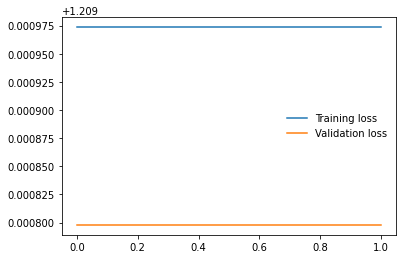

In [56]:
# visualize losses
plt.plot(training_losses, label="Training loss")
plt.plot(validation_losses, label="Validation loss")
plt.legend(frameon=False)

In [57]:
def dice_score(outputs, segmentations): # they find individual
  # outputs = torch.Size([2, 3, 128, 128, 128])
  # segmentations = torch.Size([2, 3, 128, 128, 128])
  # print(segmentations.shape)
  n_classes = segmentations.shape[0]
  print(n_classes)
  region_scores = []
  for i in range(n_classes):
    outputs = outputs.view(-1)
    segmentations = segmentations.view(-1)
    numerator = 2*(outputs*segmentations).sum()
    denominator = outputs.sum() + segmentations.sum()
    dice = (numerator) / (denominator)
    region_scores.append(dice)
  return region_scores

In [58]:
"""
1 NECROTIC TUMOUR CORE (NCR — label 1) - index 0

2 GD-ENHANCING TUMOUR (ET — label 2) - index 1

3 PERITUMORAL EDEMATOUS/INVADED TISSUE (ED — label 3) - index 2
"""

'\n1 NECROTIC TUMOUR CORE (NCR — label 1) - index 0\n\n2 GD-ENHANCING TUMOUR (ET — label 2) - index 1\n\n3 PERITUMORAL EDEMATOUS/INVADED TISSUE (ED — label 3) - index 2\n'

In [59]:
from scipy.spatial.distance import directed_hausdorff

In [60]:
def hausdorff(outputs, segmentations): # for region for every image
  print(outputs.shape)
  print(segmentations.shape)

  # for each image in batch
  h_imgs = [0,0,0]
  len_imgs = len(outputs)

  for idx in range(len_imgs): # for each image
    out = outputs[idx]
    seg = segmentations[idx]
    n_classes = out.shape[0]
    # print(n_classes)

    region_hd_scores = []
    for i in range(n_classes): # for each class
      region_out = out[i]
      region_seg = seg[i]
      # print(region_out.shape)
      # print(region_seg.shape)

      total_hd_image = 0
      for j in range(region_out.shape[0]): # for each slice
        out_slice = region_out[j]
        seg_slice = region_seg[j]
        # print(out_slice.shape)
        # print(seg_slice.shape)
        a = directed_hausdorff(out_slice, seg_slice)[0]
        b = directed_hausdorff(seg_slice, out_slice)[0]
        hd_slice = max(a, b)
        total_hd_image += hd_slice
      avg_hd_image = total_hd_image/region_out.shape[0]
      # print(avg_hd_image)
      region_hd_scores.append(avg_hd_image)
    # print(region_hd_scores)
    h_imgs[0] += region_hd_scores[0]
    h_imgs[1] += region_hd_scores[1]
    h_imgs[2] += region_hd_scores[2]
  
  for each in range(len(h_imgs)):
    h_imgs[each] = h_imgs[each]/len_imgs
  
  print(h_imgs)

  return h_imgs

In [61]:
for images, segs in testingloader:
    with torch.no_grad():
      print(len(images), len(segs))
      print(images.shape)
      print(segs.shape)
      images = images.squeeze().clone().detach().requires_grad_(True)
      # segs = segs.long() - no
      segs = segs.squeeze().clone().detach().requires_grad_(True)
      print(images.shape)
      print(segs.shape)
      output, sig_channel1, sig_channel2, sig_channel3 = model(images)
      # basically each classx_probabilities has 3 items each with 2 images in them
      print()
      print(output.shape)
      print(sig_channel1.shape)
      print(sig_channel2.shape)
      print(sig_channel3.shape)

      print()
      activated_outputs = torch.cat((sig_channel1.unsqueeze(dim=1), sig_channel2.unsqueeze(dim=1), sig_channel3.unsqueeze(dim=1)),dim=1)
      print(activated_outputs.shape)
      
      print(segs.shape)
      region_scores = dice_score(activated_outputs, segs)

      print("\n", "......."*5, "\n")

      print(len(region_scores))
      print(region_scores)
      print()

      print("1 NECROTIC TUMOUR CORE (NCR — label 1)")
      print(region_scores[0].item())
      print()

      print("2 GD-ENHANCING TUMOUR (ET — label 2)")
      print(region_scores[1].item())
      print()

      print("3 PERITUMORAL EDEMATOUS/INVADED TISSUE (ED — label 3)")
      print(region_scores[2].item())

      segs = segs.unsqueeze(dim=0)

      print("\n", "......."*5, "\n")
      hd_scores = hausdorff(activated_outputs, segs)

      print()
      print(len(hd_scores))
      print(hd_scores)
      print()

      print("1 NECROTIC TUMOUR CORE (NCR — label 1)")
      print(hd_scores[0])
      print()

      print("2 GD-ENHANCING TUMOUR (ET — label 2)")
      print(hd_scores[1])
      print()

      print("3 PERITUMORAL EDEMATOUS/INVADED TISSUE (ED — label 3)")
      print(hd_scores[2])

1 1
torch.Size([1, 1, 4, 128, 128, 128])
torch.Size([1, 1, 3, 128, 128, 128])
torch.Size([4, 128, 128, 128])
torch.Size([3, 128, 128, 128])
torch.Size([4, 128, 128, 128])
torch.Size([24, 128, 128, 128])
torch.Size([24, 128, 128, 128])
torch.Size([1, 24, 128, 128, 128])
torch.Size([1, 24, 128, 128, 128])
torch.Size([1, 48, 64, 64, 64])

next block

torch.Size([1, 48, 64, 64, 64])
torch.Size([1, 48, 64, 64, 64])
torch.Size([1, 48, 64, 64, 64])
torch.Size([1, 48, 64, 64, 64])

torch.Size([1, 48, 64, 64, 64])
torch.Size([1, 96, 32, 32, 32])

next block

torch.Size([1, 96, 32, 32, 32])
torch.Size([1, 96, 32, 32, 32])
torch.Size([1, 96, 32, 32, 32])
torch.Size([1, 96, 32, 32, 32])

torch.Size([1, 96, 32, 32, 32])
torch.Size([1, 192, 16, 16, 16])

next block

torch.Size([1, 192, 16, 16, 16])
torch.Size([1, 192, 16, 16, 16])
torch.Size([1, 192, 16, 16, 16])
torch.Size([1, 192, 16, 16, 16])

torch.Size([1, 192, 16, 16, 16])
torch.Size([1, 384, 8, 8, 8])

next block

torch.Size([1, 384, 8, 8, 8]